In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

random.seed(50)

# Importing the dataset
dataset = pd.read_csv(os.getcwd()+'//Bank_transactions.csv')



Bad key "text.kerning_factor" on line 4 in
C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dataset.head()
dataset.drop('nameOrig',axis=1,inplace=True)
dataset.drop('nameDest',axis=1,inplace=True)
dataset.drop('isFlaggedFraud',axis=1,inplace=True)

In [144]:
dataset.shape

(6362620, 8)

In [145]:
sample_dataframe = dataset.sample(n=1000000)

In [146]:
X = sample_dataframe.iloc[:,:-1].values
Y = sample_dataframe.iloc[:,-1].values

In [38]:
X[1,:]

array([15, 'PAYMENT', 2030.07, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [147]:
ct = ColumnTransformer([("oh1",OneHotEncoder(), [1])],remainder='passthrough')
X = ct.fit_transform(X)

In [148]:
X = X[:,1:]

In [149]:
X_temp = X.copy()

In [150]:
np.concatenate((X_temp[:,4][:,None] , X_temp[:,:4] , X_temp[:,5:]),axis=1,out=X)

array([[406, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [398, 1.0, 0.0, ..., 0.0, 41647.92, 266556.46],
       [595, 1.0, 0.0, ..., 0.0, 29348.97, 56846.24],
       ...,
       [165, 0.0, 0.0, ..., 9349307.5, 394075.55, 146259.25],
       [401, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [215, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

X[:,None] reshapes an N sixed 1d array to an (N,1) sized array

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

counts = np.unique(y_train, return_counts=True)

In [152]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
print(counts)

(array([0, 1], dtype=int64), array([699059,    941], dtype=int64))


In [135]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from imblearn import over_sampling as os
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN


In [155]:
y_train.shape


(700000,)

In [156]:
ada = ADASYN(sampling_strategy=0.8)
X_resampled, y_resampled = ada.fit_sample(X_train, y_train)
count = np.unique(y_resampled, return_counts=True)

# Create a pipeline

pipeline4 = make_pipeline(ADASYN(sampling_strategy='minority'),LinearSVC(random_state=1,max_iter=5000))
pipeline4.fit(X_resampled,y_resampled)


print(count)

(array([0, 1], dtype=int64), array([699059, 559197], dtype=int64))


C:\Users\prankhur\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [136]:
pipeline5 = make_pipeline(ADASYN(sampling_strategy='minority'),RandomForestClassifier(random_state=1))
pipeline5.fit(X_resampled,y_resampled)

Pipeline(steps=[('adasyn', ADASYN(sampling_strategy='minority')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

In [157]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, pipeline4.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.91      0.99      0.95      0.95      0.89    149814
          1       0.01      0.99      0.91      0.03      0.95      0.90       186

avg / total       1.00      0.91      0.99      0.95      0.95      0.89    150000



In [158]:
from sklearn.metrics import confusion_matrix, precision_score,auc,roc_auc_score,roc_curve,recall_score
cm = confusion_matrix(y_val, pipeline4.predict(X_val))
roc = roc_auc_score(y_val, pipeline4.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, pipeline4.predict(X_val))
roc_auc = auc(fpr,tpr)

In [140]:
from sklearn.metrics import confusion_matrix, precision_score,auc,roc_auc_score,roc_curve,recall_score
cm = confusion_matrix(y_val, pipeline5.predict(X_val))
roc = roc_auc_score(y_val, pipeline5.predict(X_val))
fpr2, tpr2, thresholds2 = roc_curve(y_val, pipeline5.predict(X_val))
roc_auc2 = auc(fpr2,tpr2)

In [134]:
roc

0.9440757879025886

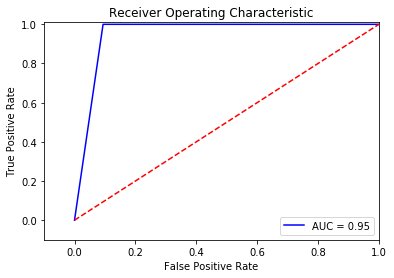

In [159]:
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

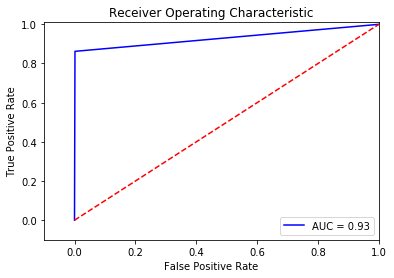

In [143]:
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, 'b',label='AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We're getting a higher AUC score for LinearSVC , which indicates that it's a better fit for our data 